# Line-of-sight effects in `lenstronomy`

This notebook presents the main features of the LineOfSight module in `lenstronomy`. The purpose of these features is to add line-of-sight corrections in the form of tidal matrices to any single-plane lensing situation.

### Theory
Following [Fleury et al. (2020)](https://arxiv.org/abs/2011.04440) and [Fleury et al. (2021)](https://arxiv.org/abs/2104.08883), line-of-sight corrections are encoded in three $2\times 2$ matrices, $\boldsymbol{\Gamma}_{\rm od}, \boldsymbol{\Gamma}_{\rm os}, \boldsymbol{\Gamma}_{\rm ds}$, which enter in the lens equation
$\boldsymbol{\beta} = \boldsymbol{\theta} - \boldsymbol{\alpha}(\boldsymbol{\theta})$ as 

$$\boldsymbol{\alpha}(\boldsymbol{\theta})
=
\boldsymbol{\Gamma}_{\rm os}\boldsymbol{\theta}
+ (1-\boldsymbol{\Gamma}_{\rm ds})
    \boldsymbol{\alpha}_0[(1-\boldsymbol{\Gamma}_{\rm od})\boldsymbol{\theta}],$$ where $\boldsymbol{\alpha}_0(\boldsymbol{\theta})$ is the displacement angle of the main lens. 

The three line-of-sight matrices $\boldsymbol{\Gamma}_{ab}$ are parameterised by the convergence $\kappa_{ab}$, complex shear $\gamma_{ab}=\gamma^{ab}_1+\mathrm{i}\gamma^{ab}_2$ and rotation $\omega_{ab}$ as

$$
\boldsymbol{\Gamma}_{ab}
=
\begin{bmatrix}
\kappa_{ab} + \gamma_1^{ab} & \gamma_2^{ab} - \omega_{ab} \\
\gamma^2_{ab} + \omega_{ab} & \kappa_{ab} - \gamma_1^{ab}
\end{bmatrix}.
$$

In [1]:
# import standard libraries
import numpy as np
import corner
import matplotlib.pyplot as plt

from astropy.cosmology import default_cosmology
cosmo = default_cosmology.get()

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    %pip install lenstronomy

%matplotlib inline

## Contents <a name="contents"></a>
1. [The SinglePlaneLOS() class and the `'LOS'` model](#los)
2. [The `'LOS_MINIMAL'` model](#los_minimal)
3. [Generating an image](#image)
4. [Including point sources and time delays](#ps)
5. [Parameter inference](#inf)
6. [Parameter inference with time delays](#inf_td)

## The SinglePlaneLOS() class and the `'LOS'` model <a name="los"></a>
[Back to contents](#contents)

In [2]:
from lenstronomy.LensModel.lens_model import LensModel

The SinglePlaneLOS module creates a lens model equipped with line-of-sight effects. This is done by proceeding as in any single-plane lensing case, but adding, in the list of profiles, the "profile" `'LOS'`. This is automatically recognised by the LensModel module which then triggers the use of SinglePlaneLOS instead of SinglePlane. For example:

In [3]:
lens_model_list = ['SIS', 'LOS']

lens_model = LensModel(lens_model_list)

print(type(lens_model.lens_model))

<class 'lenstronomy.LensModel.LineOfSight.single_plane_los.SinglePlaneLOS'>


The position of `'LOS'` in the list does not matter, but you can't add two occurrences of `'LOS'`; this triggers an error.

You also cannot use LOS effects with multi-plane lensing. This is because line-of-sight corrections are an effective way to deal with multiple deflections that are occurring besides a main (dominant) lens. If you add the `'LOS'` profile with the multi-plane option of `lenstronomy`, you will get an error.

The usual functions of single-plane lensing are then used similarly to the SinglePlane() class. The key-word arguments of `'LOS'` are treated as if `'LOS'` were an additional lens profile. The SinglePlaneLOS() class takes care of interpreting them to modify displacement angles etc. The key-word arguments consist of the three convergences, complex shears and rotations.

In [4]:
# specify parameters for the SIS profile and the LOS effects
# numbers chosen at random for this example

los_lens_model_list = ['SIS', 'LOS']

lens_model = LensModel(los_lens_model_list)

kwargs_SIS = {'theta_E': 1.0, 'center_x': 0, 'center_y': 0}

kwargs_LOS = {'kappa_od': 0, 'kappa_os': 0, 'kappa_ds': 0,
              'omega_od': 0, 'omega_os': 0, 'omega_ds': 0,
              'gamma1_od':  0.01, 'gamma2_od': 0.02,
              'gamma1_os':  0.0, 'gamma2_os': 0.01,
              'gamma1_ds':  0.04, 'gamma2_ds': -0.01}

kwargs_lens = [kwargs_SIS, kwargs_LOS]

In [5]:
# displacement angle alpha

x, y = 0.5, 0.5 # image coordinates

lens_model.alpha(x, y, kwargs=kwargs_lens)

(0.6840036220759766, 0.7548549191622171)

In [6]:
# source associated with the image

lens_model.ray_shooting(x, y, kwargs=kwargs_lens)

(-0.18400362207597665, -0.25485491916221714)

In [7]:
# Hessian matrix at the image point

lens_model.hessian(x, y, kwargs=kwargs_lens)

(0.7062734665036974,
 -0.6962734665036974,
 -0.739969773243907,
 0.7499697732439072)

The Fermat potential used to calculate time delays in the presence of tidal line-of-sight effects is given by
$$
T(\boldsymbol{\theta},\boldsymbol{\beta}) = \left[\frac{1}{2}(\boldsymbol{\theta}-\boldsymbol{\beta}')\cdot\boldsymbol{\mathcal{A}}_{{\rm LOS}}(\boldsymbol{\theta}-\boldsymbol{\beta}')-\psi_{{\rm eff}}(\boldsymbol{\theta}) \right],
$$
where $ \boldsymbol{\mathcal{A}}_{{\rm LOS}} \equiv \boldsymbol{\mathcal{A}}_{\rm od}^T\boldsymbol{\mathcal{A}}_{\rm ds}^{-1}\boldsymbol{\mathcal{A}}_{\rm os} $ is the "line-of-sight" amplification matrix, $\boldsymbol{\beta}' = \boldsymbol{\mathcal{A}}_{\rm os}^{-1}\boldsymbol{\beta} $ is the modified source position, and  $\psi_{{\rm eff}}(\boldsymbol{\theta}) = \psi_0(\boldsymbol{\mathcal{A}}_{\rm od}\boldsymbol{\theta})$    
is the potential of the main lens, evaluated at a position modified by the foreground amplification matrix. The amplification matrices are related to their shear matrix counterparts as, for example, $\boldsymbol{\mathcal{A}}_{\rm od} = \boldsymbol{1}-\boldsymbol{\Gamma}_{\rm od}$.


If `'LOS'` is included in the list of lens profiles, the Fermat potential and arrival times will also be calculated with line-of-sight modifications. The latter requires the redshifts of the lens and source to be included when initialising the LensModel class.

In [8]:
# Fermat potential at the image point

lens_model.fermat_potential(x, y, kwargs_lens=kwargs_lens)

-0.19239358061967793

In [9]:
z_lens = 0.5

z_source = 1.0

lens_model = LensModel(lens_model_list=los_lens_model_list, z_lens=z_lens, z_source=z_source)

In [10]:
# arrival time of the image position in units of days

lens_model.arrival_time(x, y, kwargs_lens=kwargs_lens)

-24.5685474859259

## The `'LOS_MINIMAL'` model<a name="los_minimal"></a>
[Back to contents](#contents)

When attempting to reconstruct an image, we can use our ignorance of the underlying source to reduce the number of line-of-sight parameters. Multiplying the lens equation with $(1 - \boldsymbol{\Gamma}_{\rm od})(1 - \boldsymbol{\Gamma}_{\rm ds})^{-1}$ yields
    
$$
\tilde{\boldsymbol{\beta}}
= (1 - \boldsymbol{\Gamma}_{\rm LOS}) \boldsymbol{\theta}
    - (1 - \boldsymbol{\Gamma}_{\rm od})
        \boldsymbol{\alpha}_0[(1-\boldsymbol{\Gamma}_{\rm od})\boldsymbol{\theta}],
$$
with
$$
\tilde{\boldsymbol{\beta}}
\equiv (1 - \boldsymbol{\Gamma}_{\rm od})
        (1 - \boldsymbol{\Gamma}_{\rm ds})^{-1}
        \boldsymbol{\beta}
\approx (1 - \boldsymbol{\Gamma}_{\rm od} + \boldsymbol{\Gamma}_{\rm })
        \boldsymbol{\beta},
$$

$$
\boldsymbol{\Gamma}_{\rm LOS}
\equiv 1-
        (1 - \boldsymbol{\Gamma}_{\rm od})
        (1 - \boldsymbol{\Gamma}_{\rm ds})^{-1}
        (1 - \boldsymbol{\Gamma}_{\rm os})
\approx \boldsymbol{\Gamma}_{\rm os} + \boldsymbol{\Gamma}_{\rm od} - \boldsymbol{\Gamma}_{\rm ds}.
$$

Therefore, any image can actually be analysed with the above model that only has two correction matrices, $\boldsymbol{\Gamma}_{\rm od}, \boldsymbol{\Gamma}_{\rm LOS}$ instead of three.

The above is equivalent to having `'LOS'` but with $\boldsymbol{\Gamma}_{ds}=\boldsymbol{\Gamma}_{od}$. This constraint is automatically implemented using the `'LOS_MINIMAL'` "profile" instead of `'LOS'`. Its use is exactly the same as `'LOS'`, though its key-word arguments are different, reflecting the reduction of the parameters in this minimal model.

A detailed discussion of the minimal model can be found in [Fleury et al. (2021)](https://arxiv.org/abs/2104.08883) (section 3.2).

In [11]:
minimal_lens_model_list = ['SIS', 'LOS_MINIMAL']

lens_model = LensModel(minimal_lens_model_list)

In [12]:
kwargs_SIS = {'theta_E': 1.0, 'center_x': 0.0, 'center_y': 0.0}

kwargs_minimal = {'kappa_od': 0.0, 'kappa_los': 0.0,
                  'omega_od': 0.0, 'omega_los': 0.0,
                  'gamma1_od':  0.05, 'gamma2_od':  0.0,
                  'gamma1_los': 0.0,  'gamma2_los': 0.01}

minimal_kwargs_lens = [kwargs_SIS, kwargs_minimal]

Displacement angles, ray shooting, Fermat potential etc. work in the same way as before, for instance:

In [13]:
x, y = 0.5, 0.5 # image coordinates

lens_model.ray_shooting(x, y, kwargs=minimal_kwargs_lens)

(-0.14236765777066995, -0.2836125680799597)

## Generating an image <a name="image"></a>
[Back to contents](#contents)

The production of an image is the same as for single-plane lensing. In this example we use the SimulationAPI module to generate the image, for which there is a [separate tutorial notebook](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/Simulations/simulation_api.ipynb).

In [14]:
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.SimulationAPI.ObservationConfig.HST import HST

In [15]:
# create a source
source_model_list = ['SERSIC_ELLIPSE']

magnitude_source = 24.0

R_sersic_source = 0.03
n_sersic_source = 1.0
e1_source = 0.3
e2_source = 0.0
x_source = 0.1
y_source = 0.1

kwargs_sersic = {'magnitude': magnitude_source,
                 'R_sersic': R_sersic_source, 
                 'n_sersic': n_sersic_source, 
                 'e1': e1_source, 
                 'e2': e2_source, 
                 'center_x': x_source, 
                 'center_y': y_source}

kwargs_source_mag = [kwargs_sersic]

In [16]:
# use the simple SIS + LOS model defined above
image_lens_model_list = ['SIS', 'LOS']

kwargs_lens = [kwargs_SIS, kwargs_LOS]

# gather the full model
kwargs_model = {'lens_model_list': image_lens_model_list,
                'source_light_model_list': source_model_list}

In [17]:
# get the telescope settings for HST
psf = 'GAUSSIAN'
band = HST(band='WFC3_F160W', psf_type=psf) # this chooses the specific camera and filter of HST
kwargs_band = band.kwargs_single_band() # we are only considering a single band (i.e. a single wavelength/filter)
pixel_size = band.camera['pixel_scale'] # in arcsec

kwargs_psf = {'psf_type': psf,
              'fwhm': kwargs_band['seeing'],
              'pixel_size': pixel_size,
              'truncation': 5}

# define the numerics
kwargs_numerics = {'supersampling_factor': 1,
                   'supersampling_convolution': False}

# call the simulation API class
sim = SimAPI(numpix = 49, # number of pixels we want in our image
             kwargs_single_band = kwargs_band, # give the SimAPI class the keyword arguments for HST that we got above
             kwargs_model = kwargs_model)

kwargs_data = sim.kwargs_data

In [18]:
# convert magnitudes into amplitudes
# we don't care about lens light or point source for the moment
_, kwargs_source, _ = sim.magnitude2amplitude(kwargs_source_mag=kwargs_source_mag)

In [19]:
# now use the SimAPI class to generate a noisy image in one step
imSim = sim.image_model_class(kwargs_numerics)

image = imSim.image(kwargs_lens = kwargs_lens,
                    kwargs_source = kwargs_source)

image_noisy = image + sim.noise_for_model(model = image)

kwargs_data['image_data'] = image_noisy

/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_77852/3911142317.py:11: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_noisy), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])


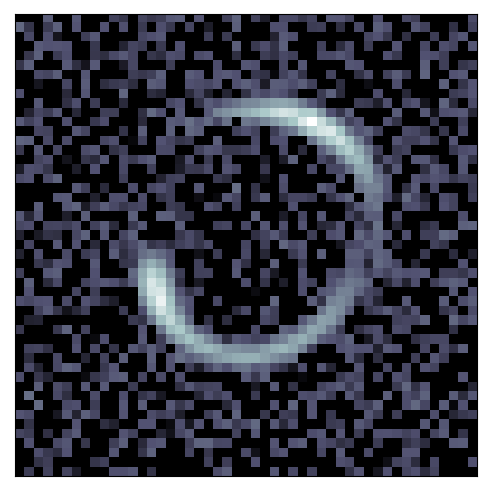

In [20]:
# plot the image
cmap_string = 'bone'
cmap = plt.get_cmap(cmap_string).copy()
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 1

f, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
im = ax.matshow(np.log10(image_noisy), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

## Including point sources and time delays <a name="ps"> </a>
We can add a point source to our set up and compute the time delays between the images.

[Back to contents](#contents)

In [21]:
# solve the lens equation
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

lens_model = LensModel(image_lens_model_list)

ra_source, dec_source = 0.11, 0.09 # the centre of the AGN is slightly offset from that of the host galaxy

lensEquationSolver = LensEquationSolver(lens_model)

x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4)

# compute lensing magnification at image positions
mag = lens_model.magnification(x_image, y_image, kwargs_lens)

mag = np.abs(mag)  # ignore the sign of the magnification

In [22]:
# set up the point source
point_amp = mag * 500  # multiply by intrinsic quasar brightness (in counts/s)

kwargs_ps = [{'ra_image': x_image, 
              'dec_image': y_image,
              'point_amp': point_amp}]  # quasar point source position in the lens plane and intrinsic brightness

point_source_list = ['LENSED_POSITION']

kwargs_model_ps = {'lens_model_list': image_lens_model_list,
                   'source_light_model_list': source_model_list,
                   'point_source_model_list': point_source_list}

In [23]:
# call the simulation API class with the new model
sim_ps = SimAPI(numpix = 49, 
                kwargs_single_band = kwargs_band, 
                kwargs_model = kwargs_model_ps)

kwargs_data_ps = sim_ps.kwargs_data

In [24]:
# add the noise
imSim_ps = sim_ps.image_model_class(kwargs_numerics)

image_ps = imSim_ps.image(kwargs_lens = kwargs_lens,
                          kwargs_source = kwargs_source,
                          kwargs_ps = kwargs_ps)

image_noisy_ps = image_ps + sim_ps.noise_for_model(model = image_ps)

kwargs_data_ps['image_data'] = image_noisy_ps

/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_77852/2379999201.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("bone").copy()
  cmap.set_bad(color='k', alpha=1.)
/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_77852/2379999201.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("bone").copy()
  cmap.set_under('k')
/var/folders/yp/rr1r4kgd2f3fpggf8vqnkqym0000gn/T/ipykernel_77852/2379999201.py:12: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(i

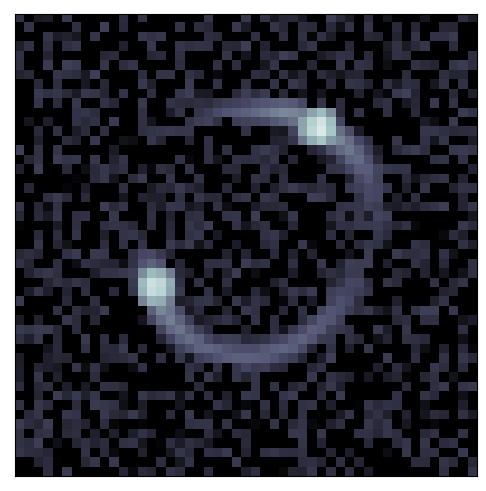

In [25]:
# plot the image
cmap_string = 'bone'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

# change the contrast of the image slightly
v_min = -4
v_max = 4

f, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
im = ax.matshow(np.log10(image_noisy_ps), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

### Time delays

In [26]:
# calculate time delays and the time delay distance
from lenstronomy.Analysis.td_cosmography import TDCosmography
from lenstronomy.Cosmo.lens_cosmo import LensCosmo

td_cosmo = TDCosmography(z_lens, z_source, kwargs_model_ps, cosmo_fiducial=cosmo)

# time delays, the unit [days] is matched when the lensing angles are in arcsec
t_days = td_cosmo.time_delays(kwargs_lens, kwargs_ps, kappa_ext=0)

# relative delays (observable); the convention is relative to the first image
dt_days =  t_days[1:] - t_days[0]

# errors can be assigned to the measured relative delays (full covariance matrix not yet implemented)
dt_sigma = [4]  # Gaussian errors

# realisation of the measurement with the quoted error bars
dt_measured = np.random.normal(dt_days, dt_sigma)

print('The measured relative delays are {} days.'.format(dt_measured))

lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)

ddt = lensCosmo.ddt

print('The time delay distance is {} Mpc.'.format(ddt))

The measured relative delays are [37.02769893] days.
The time delay distance is 4560.611423943215 Mpc.


## Parameter inference <a name="inf"></a>
[Back to contents](#contents)

The implementation of the line-of-sight effects means that `lenstronomy` treats the `'LOS'` and `'LOS_MINIMAL'` options as lens profiles. This means that it deals with their parameters (convergences, shears, rotations) in the same way as it would do with the parameters of any other lens model, such as the Einstein radius or the ellipticity. This means that parameter inference with the LOS effects works exactly as it does with any other lens model in `lenstronomy`.

As an example, we can fit the first image produced above with a model consisting of an SIS lens plus the `'LOS_MINIMAL'` model.

In [27]:
# compute the expected values of the LOS shear from the od, ds and os shears
# note that this holds at linear level only!
gamma1_los = kwargs_LOS['gamma1_od'] + kwargs_LOS['gamma1_os'] - kwargs_LOS['gamma1_ds']
gamma2_los = kwargs_LOS['gamma2_od'] + kwargs_LOS['gamma2_os'] - kwargs_LOS['gamma2_ds']
omega_los = 0.0

In [28]:
fitting_lens_model_list = ['SIS', 'LOS_MINIMAL']

# initialise the lists of parameters
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# parameters for the SIS (in this example we only sample the Einstein radius)
# specify which parameters are fixed 
# and choose the initial value, step size, lower and higher limits for the sampled parameters

fixed_lens.append({'center_x': 0.0, 'center_y': 0.0})
kwargs_lens_init.append({'theta_E': 1.0})
kwargs_lens_sigma.append({'theta_E': 0.001})
kwargs_lower_lens.append({'theta_E': 0.01})
kwargs_upper_lens.append({'theta_E': 10})

In [29]:
# line-of-sight parameters
# we vary the shears and also allow for LOS rotation
fixed_lens.append({'kappa_od': 0.0, 'omega_od': 0.0, 'kappa_los': 0.0})
params = ['gamma1_od', 'gamma2_od', 'gamma1_los', 'gamma2_los', 'omega_los']

# initialise the LOS kwargs close to their expected values
kwargs_lens_init.append({'gamma1_od': kwargs_LOS['gamma1_od'],
                         'gamma2_od': kwargs_LOS['gamma2_od'],
                         'gamma1_los': gamma1_los,
                         'gamma2_los': gamma2_los,
                         'omega_los': omega_los})

kwargs_lens_sigma.append({param: 0.01 for param in params})
kwargs_lower_lens.append({param: -0.5 for param in params})
kwargs_upper_lens.append({param: 0.5 for param in params})

lens_params = [kwargs_lens_init,
               kwargs_lens_sigma,
               fixed_lens,
               kwargs_lower_lens,
               kwargs_upper_lens]
kwargs_lens_init

[{'theta_E': 1.0},
 {'gamma1_od': 0.01,
  'gamma2_od': 0.02,
  'gamma1_los': -0.03,
  'gamma2_los': 0.04,
  'omega_los': 0.0}]

<div class="alert alert-block alert-warning">
<b>Note:</b> The line-of-sight rotation is sampled in order to account for non-linear effects coming from the inversion of matrices and matrix mutiplication. It is necessary to get a good fit, but can be thought of as a nuisance parameter.

In [30]:
# now for the source
source_model_list = ['SERSIC_ELLIPSE']

fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []
fixed_source.append({})
import copy
kwargs_sersic_init = copy.deepcopy(kwargs_sersic)
kwargs_sersic_init.pop("magnitude")
kwargs_source_init.append(kwargs_sersic_init)
kwargs_source_sigma.append({'R_sersic': 0.001, 'n_sersic': 0.001, 'e1': 0.01, 'e2': 0.01,'center_x': 0.0001, 'center_y': 0.0001})
kwargs_lower_source.append({'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5,'center_x': -10.0, 'center_y': -10.0})
kwargs_upper_source.append({'R_sersic': 10.0, 'n_sersic': 5.0,'e1': 0.5, 'e2': 0.5,'center_x': 10.0, 'center_y': 10.0})

source_params = [kwargs_source_init, kwargs_source_sigma,
                 fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params}


In [31]:
kwargs_source

[{'R_sersic': 0.03,
  'n_sersic': 1.0,
  'e1': 0.3,
  'e2': 0.0,
  'center_x': 0.1,
  'center_y': 0.1,
  'amp': 564.8307247876069}]

In [32]:
# run the MCMC
from lenstronomy.Workflow.fitting_sequence import FittingSequence

kwargs_likelihood = {'source_marg': True}

kwargs_model = {'lens_model_list': fitting_lens_model_list,
                'source_light_model_list': source_model_list}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {'multi_band_list': multi_band_list,
                     'multi_band_type': 'multi-linear'}

kwargs_constraints = {}

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['MCMC', {'n_burn': 1000, 'n_run': 1000, 'walkerRatio': 10, 'sigma_scale': 1.0}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

print("""Best-fit parameters:
{}
""".format(kwargs_result))

MCMC selected. Sampling with default option emcee.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:48<00:00, 18.36it/s]

Computing the MCMC...
Number of walkers =  120
Burn-in iterations:  1000
Sampling iterations (in current run): 2000
109.03373289108276 time taken for MCMC sampling
Best-fit parameters:
{'kwargs_lens': [{'theta_E': 0.9978736620948628, 'center_x': 0.0, 'center_y': 0.0}, {'kappa_od': 0.0, 'gamma1_od': 0.009787172678045119, 'gamma2_od': 0.02039892677111539, 'omega_od': 0.0, 'kappa_los': 0.0, 'gamma1_los': -0.030539943024716066, 'gamma2_los': 0.04062478000698153, 'omega_los': 0.0005231680850191608}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.02980977244676311, 'n_sersic': 0.9963778992991799, 'e1': 0.3261233865718355, 'e2': -0.03417850356626387, 'center_x': 0.09997798149491655, 'center_y': 0.09352083076822738}], 'kwargs_lens_light': [], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': [], 'kwargs_tracer_source': []}



/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/plot_util.py:355: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gist_heat").copy()
  cmap_new.set_bad(color="k", alpha=1.0)
/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/plot_util.py:356: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gist_heat").copy()
  cmap_new.set_under("k")
/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:161: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/Users/

-1.040258616538355 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.040258616538355


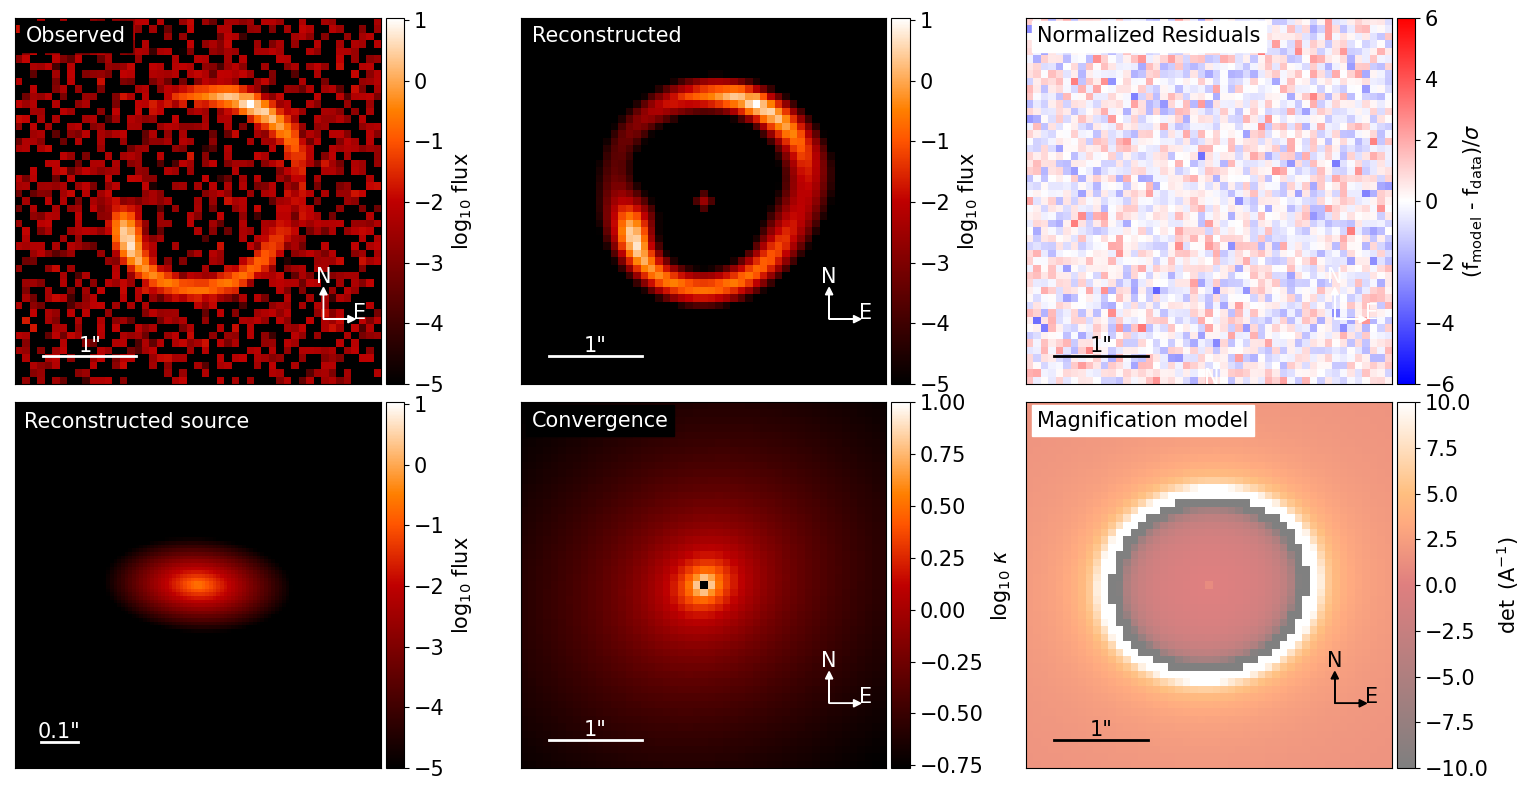

In [33]:
# analyse the MCMC and display best-fit image
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result,
                      arrow_size=0.02, cmap_string='gist_heat')
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

number of non-linear parameters in the MCMC process:  12
parameters in order:  ['theta_E_lens0', 'gamma1_od_lens1', 'gamma2_od_lens1', 'gamma1_los_lens1', 'gamma2_los_lens1', 'omega_los_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0']
number of evaluations in the MCMC process:  120000


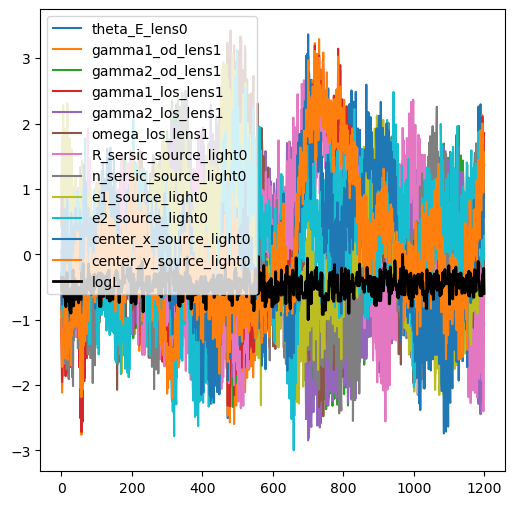

In [34]:
# convergence of the MCMC

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[0]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])

In [35]:
# Constraints on the parameters: define the labels and expected values

labels = [r'$\theta_{\rm E}$',
          r'$\gamma^{od}_1$',
          r'$\gamma^{od}_2$',
          r'$\gamma^{\rm LOS}_1$',
          r'$\gamma^{\rm LOS}_2$',
          r'$\omega_{\rm LOS}$',
          r'$R_{\rm Sérsic}$',
          r'$n_{\rm Sérsic}$',
          r'$e_1^{\rm source}$',
          r'$e_2^{\rm source}$',
          r'$x_s$',
          r'$y_s$']

expected_values = [kwargs_SIS['theta_E'],
                   kwargs_LOS['gamma1_od'],
                   kwargs_LOS['gamma2_od'],
                   gamma1_los,
                   gamma2_los,
                   omega_los, 
                   kwargs_sersic['R_sersic'],
                   kwargs_sersic['n_sersic'],
                   kwargs_sersic['e1'],
                   kwargs_sersic['e2'],
                   kwargs_sersic['center_x'],
                   kwargs_sersic['center_y']]

n, num_param = np.shape(samples_mcmc)

### Contour plot

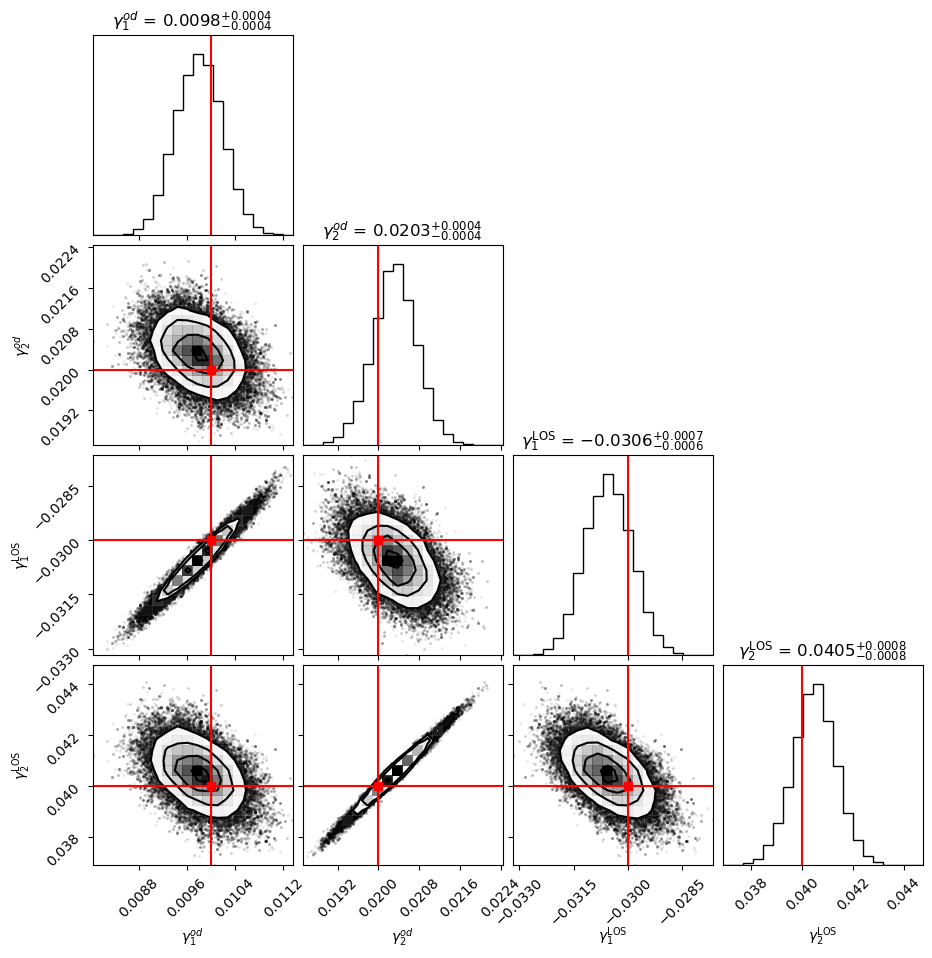

In [36]:
# have a look at the constraints on the line-of-sight parameters

plot = corner.corner(samples_mcmc[:,1:5],
                     labels=labels[1:5],
                     truths=expected_values[1:5],
                     truth_color='r',
                     show_titles=True,
                     title_fmt = '.4f')

We see that we can recover the expected line-of-sight shear with an excellent precision and accuracy.

## Parameter inference with time delays <a name="inf_td"></a>

Point sources and time delay information can also be included in the parameter inference, and the time delay distance measured.

[Back to contents](#contents)


In [37]:
fixed_ps = []
kwargs_ps_init = []
kwargs_ps_sigma = []
kwargs_lower_ps = []
kwargs_upper_ps = []

# Define parameters
fixed_ps.append({})
kwargs_ps_init.append({'ra_image': x_image, 'dec_image': y_image})
kwargs_ps_sigma.append({'ra_image': [0.0001]*len(x_image),  'dec_image': [0.0001]*len(y_image)})
kwargs_lower_ps.append({'ra_image': [-10.0]*len(x_image), 'dec_image': [-10.0]*len(y_image)})
kwargs_upper_ps.append({'ra_image': [10.0]*len(x_image),  'dec_image': [10.0]*len(y_image)})

ps_params = [kwargs_ps_init, 
             kwargs_ps_sigma,
             fixed_ps, 
             kwargs_lower_ps, 
             kwargs_upper_ps]

fixed_cosmo = [{}]
kwargs_cosmo_init = {'D_dt': ddt}
kwargs_cosmo_sigma = {'D_dt': 100}
kwargs_lower_cosmo = {'D_dt': 0}
kwargs_upper_cosmo = {'D_dt': 10000}

cosmo_params = [kwargs_cosmo_init, 
                kwargs_cosmo_sigma, 
                fixed_cosmo, 
                kwargs_lower_cosmo, 
                kwargs_upper_cosmo]

kwargs_params_ps = {'lens_model': lens_params,
                   'source_model': source_params,
                   'point_source_model': ps_params,
                   'special': cosmo_params}

print(lens_params[0], source_params[0], ps_params[0])
print('++++')
print()

[{'theta_E': 1.0}, {'gamma1_od': 0.01, 'gamma2_od': 0.02, 'gamma1_los': -0.03, 'gamma2_los': 0.04, 'omega_los': 0.0}] [{'R_sersic': 0.03, 'n_sersic': 1.0, 'e1': 0.3, 'e2': 0.0, 'center_x': 0.1, 'center_y': 0.1}] [{'ra_image': array([ 0.62998589, -0.77389259]), 'dec_image': array([ 0.98828507, -0.35159887])}]
++++



In [38]:
# run the MCMC

kwargs_likelihood_ps = {'source_marg': True,
                       'time_delay_likelihood':True,
                       'source_position_sigma': 0.001}  # demand that the lens equation is satisfied to certain uncertainty level

multi_band_list_ps = [[kwargs_data_ps, kwargs_psf, kwargs_numerics]]

kwargs_data_joint_ps = {'multi_band_list': multi_band_list_ps,
                       'multi_band_type': 'multi-linear',
                       'time_delays_measured': dt_measured,
                       'time_delays_uncertainties': dt_sigma}

kwargs_constraints_ps = {'num_point_source_list': [len(x_image)], 'Ddt_sampling': True}

kwargs_model_ps = {'lens_model_list': fitting_lens_model_list,
                  'source_light_model_list': source_model_list,
                  'point_source_model_list': point_source_list}

fitting_seq_ps = FittingSequence(kwargs_data_joint_ps, kwargs_model_ps, 
                                 kwargs_constraints_ps, kwargs_likelihood_ps, 
                                 kwargs_params_ps)


In [39]:
chain_list_ps = fitting_seq_ps.fit_sequence(fitting_kwargs_list)

kwargs_result_ps = fitting_seq_ps.best_fit()

print("""Best-fit parameters:
{}
""".format(kwargs_result_ps))

MCMC selected. Sampling with default option emcee.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [33:46<00:00,  1.01s/it]

Computing the MCMC...
Number of walkers =  170
Burn-in iterations:  1000
Sampling iterations (in current run): 2000
2026.3526871204376 time taken for MCMC sampling
Best-fit parameters:
{'kwargs_lens': [{'theta_E': 0.9992465786632821, 'center_x': 0.0, 'center_y': 0.0}, {'kappa_od': 0.0, 'gamma1_od': 0.010579307198824425, 'gamma2_od': 0.01956241910237149, 'omega_od': 0.0, 'kappa_los': 0.0, 'gamma1_los': -0.028684144346050145, 'gamma2_los': 0.03890070818113338, 'omega_los': 0.0006583043820952215}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.03012714392364354, 'n_sersic': 1.0071600607225868, 'e1': 0.32632708793722986, 'e2': -0.03131036408162571, 'center_x': 0.10020898592449008, 'center_y': 0.09431179155160378}], 'kwargs_lens_light': [], 'kwargs_ps': [{'ra_image': array([ 0.62999104, -0.77387734]), 'dec_image': array([ 0.98829534, -0.35162625]), 'point_amp': array([1., 1.])}], 'kwargs_special': {'D_dt': 4267.543486924597}, 'kwargs_extinction': [], 'kwargs_tracer_source': []}



/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/plot_util.py:355: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gist_heat").copy()
  cmap_new.set_bad(color="k", alpha=1.0)
/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/plot_util.py:356: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gist_heat").copy()
  cmap_new.set_under("k")
/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:161: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/Users/

-0.990245742024816 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.990245742024816


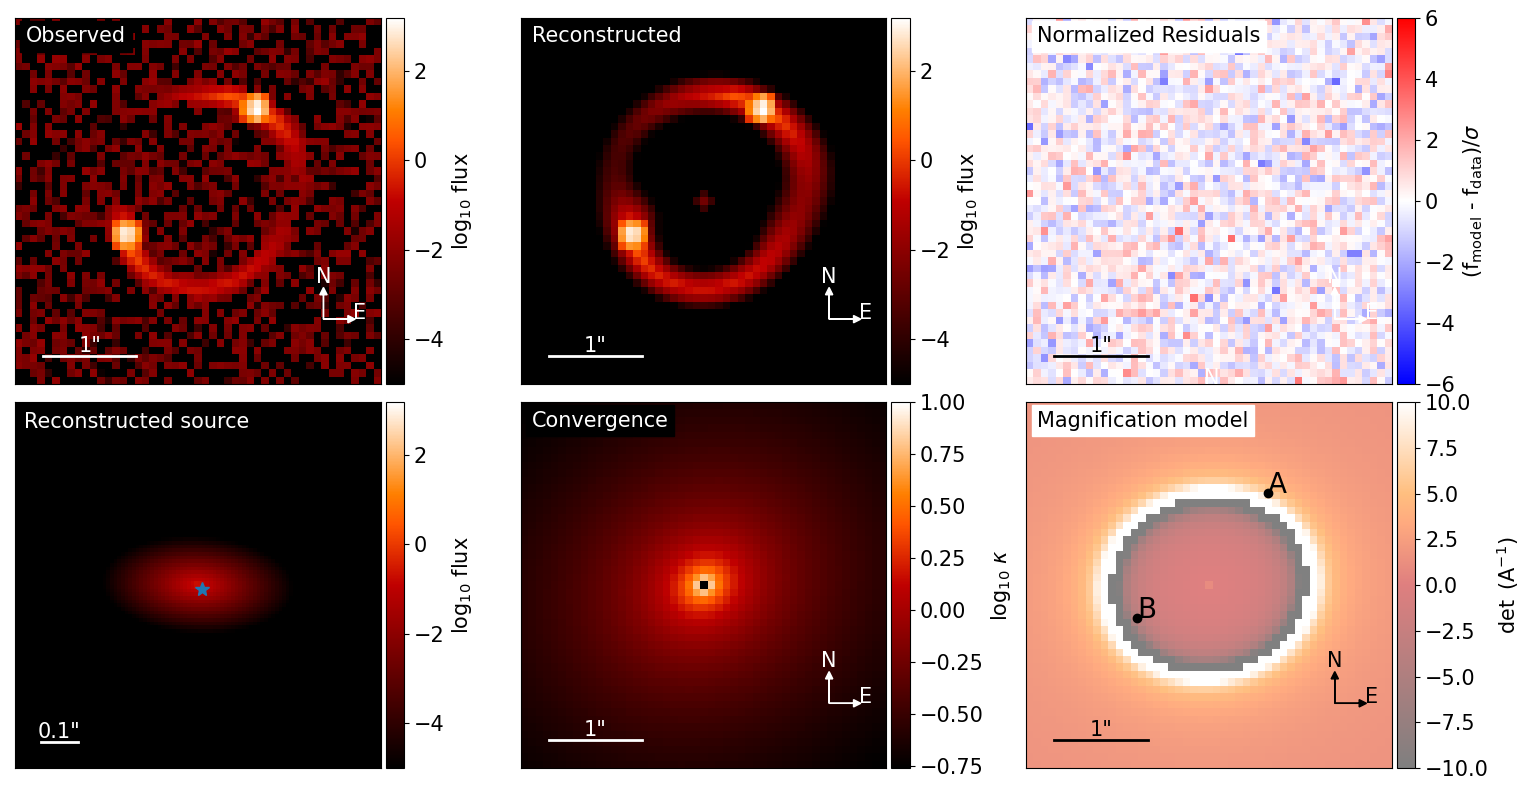

In [40]:
# Analyse the MCMC and display best-fit image

modelPlot_ps = ModelPlot(multi_band_list_ps, kwargs_model_ps, 
                         kwargs_result_ps, arrow_size=0.02, 
                         cmap_string='gist_heat')
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot_ps.data_plot(ax=axes[0,0])
modelPlot_ps.model_plot(ax=axes[0,1])
modelPlot_ps.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot_ps.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot_ps.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot_ps.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

number of non-linear parameters in the MCMC process:  17
parameters in order:  ['theta_E_lens0', 'gamma1_od_lens1', 'gamma2_od_lens1', 'gamma1_los_lens1', 'gamma2_los_lens1', 'omega_los_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'D_dt']
number of evaluations in the MCMC process:  170000


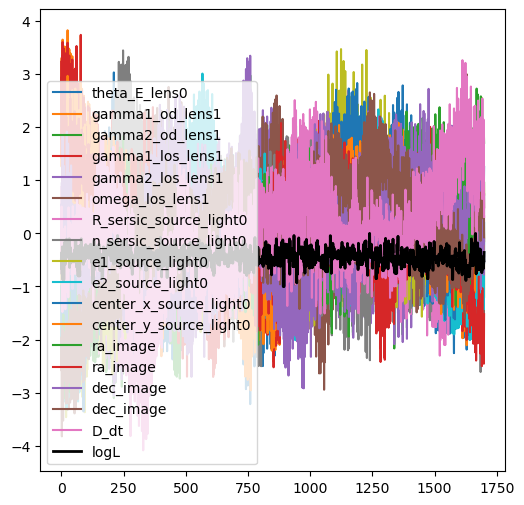

In [41]:
for i in range(len(chain_list_ps)):
    chain_plot.plot_chain_list(chain_list_ps, i)
    
sampler_type_ps, samples_mcmc_ps, param_mcmc_ps, dist_mcmc_ps  = chain_list_ps[0]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc_ps))
print("parameters in order: ", param_mcmc_ps)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc_ps)[0])

In [42]:
# Constraints on the parameters: define the labels and expected values

labels_ps = [r'$\theta_{\rm E}$',
             r'$\gamma^{od}_1$',
             r'$\gamma^{od}_2$',
             r'$\gamma^{\rm LOS}_1$',
             r'$\gamma^{\rm LOS}_2$',
             r'$\omega_{\rm LOS}$',
             r'$R_{\rm Sérsic}$',
             r'$n_{\rm Sérsic}$',
             r'$e_1^{\rm source}$',
             r'$e_2^{\rm source}$',
             r'$x_s$',
             r'$y_s$',
             r'$D_{\rm \Delta t}$']

expected_values_ps = [kwargs_SIS['theta_E'],
                      kwargs_LOS['gamma1_od'],
                      kwargs_LOS['gamma2_od'],
                      gamma1_los,
                      gamma2_los,
                      omega_los,
                      kwargs_sersic['R_sersic'],
                      kwargs_sersic['n_sersic'],
                      kwargs_sersic['e1'],
                      kwargs_sersic['e2'],
                      kwargs_sersic['center_x'],
                      kwargs_sersic['center_y'],
                      ddt]

n_ps, num_param_ps = np.shape(samples_mcmc_ps)

### Contour plot

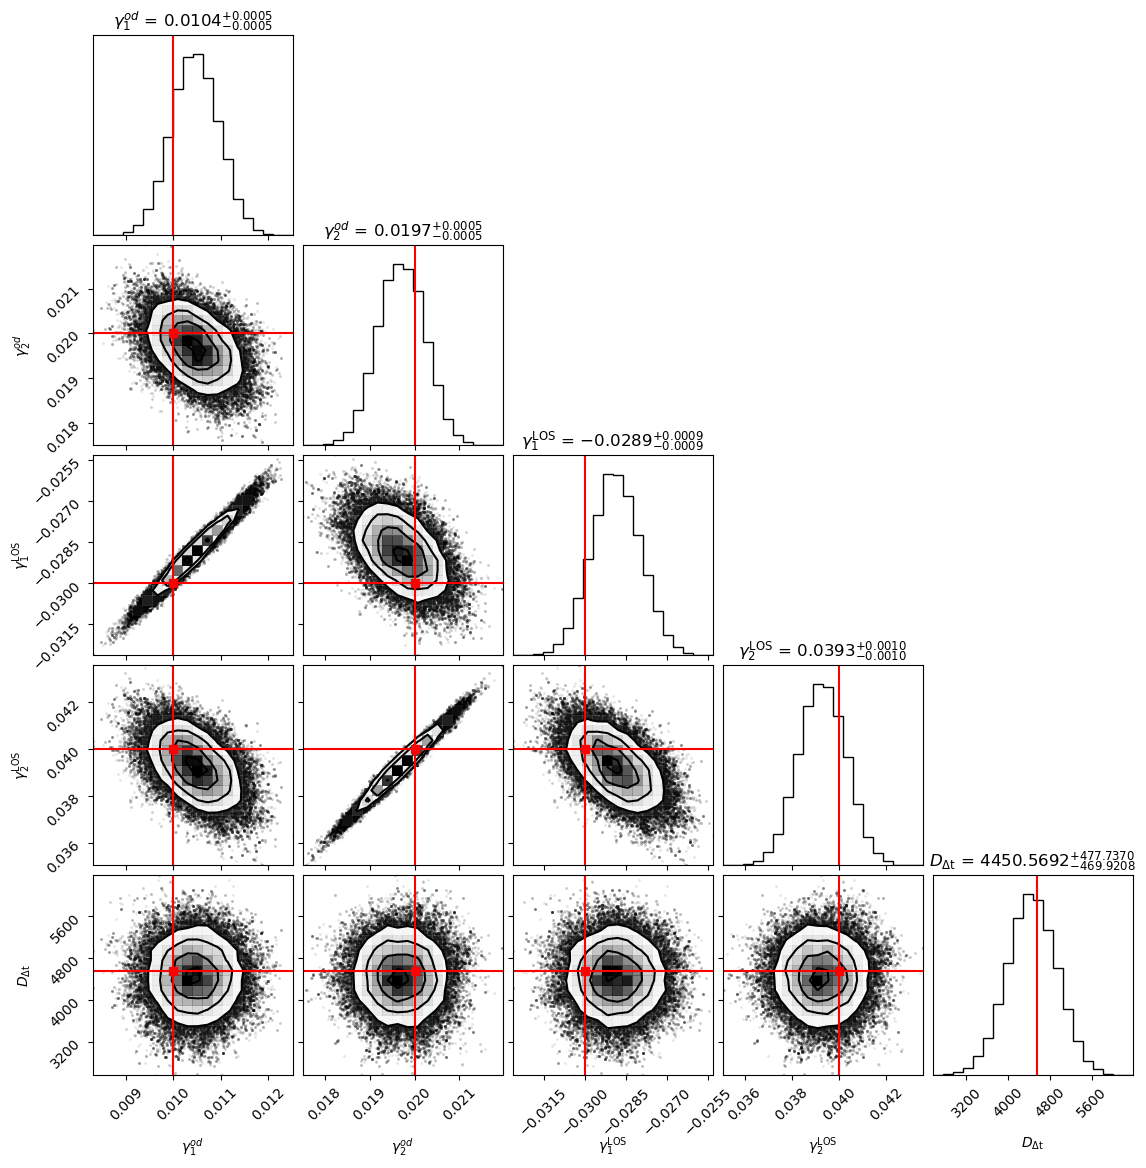

In [43]:
# use the Param class of lenstronomy to access only the LOS and time delay parameters for plotting

from lenstronomy.Sampling.parameters import Param

param = Param(kwargs_model_ps, fixed_lens, fixed_source, 
              kwargs_fixed_ps = fixed_ps, 
              kwargs_fixed_special = fixed_cosmo, 
              kwargs_lens_init = kwargs_result_ps['kwargs_lens'], 
              **kwargs_constraints_ps)

mcmc_new_list = []

labels_new = [r'$\gamma^{od}_1$', 
              r'$\gamma^{od}_2$', 
              r'$\gamma^{\rm LOS}_1$', 
              r'$\gamma^{\rm LOS}_2$', 
              r'$D_{\rm \Delta t}$']

expected_values_new = [kwargs_LOS['gamma1_od'],
                       kwargs_LOS['gamma2_od'],
                       gamma1_los,
                       gamma2_los,
                       ddt]

for i in range(len(samples_mcmc_ps)):
    kwargs_res = param.args2kwargs(samples_mcmc_ps[i])
    D_dt       = kwargs_res['kwargs_special']['D_dt']
    gamma1_od  = kwargs_res['kwargs_lens'][1]['gamma1_od']
    gamma2_od  = kwargs_res['kwargs_lens'][1]['gamma2_od']
    gamma1_LOS = kwargs_res['kwargs_lens'][1]['gamma1_los']
    gamma2_LOS = kwargs_res['kwargs_lens'][1]['gamma2_los']
    mcmc_new_list.append([gamma1_od, gamma2_od, gamma1_LOS, gamma2_LOS, D_dt])

plot = corner.corner(np.array(mcmc_new_list), 
                     labels = labels_new,
                     truths = expected_values_new,
                     truth_color = 'r', 
                     show_titles = True,
                     title_fmt = '.4f')


[Back to contents](#contents)